# PSD Estimation and Windowing

Below we analyze strain data to see if we can estimate the PSD.

According to the paper *A guide to LIGO-Virgo detector noise extraction*, we expect to see spectral leakage and phase correlation if we do not apply windowing. 

We first generate data from the advanced LIGO O4 design PSD, which is identically zero below 20 Hz. We show that this aggressive high-pass at 20 Hz eliminates these artifacts in the frequency domain, and one can use large segments to estimate the PSD of the noise, even without windowing.

Then we use actual O1 HOFT (i.e. $h$ of $t$) calibrated data, which are high-passed at 8 Hz and there we see that both spectral leakage and phase correlation appear in the Frequency domain. These effects do disappear if we window the data. Thus both of these are artifacts of the boundary. 

As a result one should **always** window finite-length signals **before** doing any Frequency domain calculation to deal with these boundary effects.  

**Notes on PSD implementations**: The Power Spectral Density Estimation is implemented in various different commonly used libraries. Below are some details on each implementation. For real data all return one-sided PSD and the ASD is the square root of the PSD.

- `scipy.signal`: The PSD estimation with the Welch Method is `scipy.signal.welch`. By default it uses Hann windowing and 50% overlap. Two of its parameters, `nperseg` and `nfft` are used to specify the number of time domain points used in each FFT, and the number of points of each FFT. While by default `nfft` is assigned to be the same as `nperseg`, one can make it larger than `nperseg` (but not smaller) to zero-pad to get a smoother FFT. `nperseg` is by default 256. Read more [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html#r34b375daf612-1) 

- `gwpy.timeseries`: Its PSD estimation is a method on TimeSeries objects, i.e `TimeSeries.psd()`. By default it uses the Welch method with Hann windowing and 50% overlap. It is actually implemented using the correcponding `scipy` method we saw above. The main difference in the defaults seems to be that its parameter `fftlength` defaults to single segment of full length (still Hann windowed probably). Read more [here](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.psd)

- `matplotlib.mlab`: The precursor to the `scipy.signal` method (the code is almost identical). It uses by the Welch method (no other method available). Mostly identical to `scipy`, but here `nfft` gives the number of timedomain points per segment, while `pad_to` gives the number of points of each FFT after possibly padding. `pad_to` is set by default equal to `nfft` and `nfft` is set by default to 256.  

In [9]:
import bilby
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
bilby.__version__

'1.0.2: release'

## 1 second segments from PSD 

In [10]:
H1 = bilby.gw.detector.get_empty_interferometer('H1')
L1 = bilby.gw.detector.get_empty_interferometer('L1')
print(H1)
print(L1)

Interferometer(name='H1', power_spectral_density=PowerSpectralDensity(psd_file='None', asd_file='aLIGO_O4_high_asd.txt'), minimum_frequency=20.0, maximum_frequency=2048.0, length=4.0, latitude=46.45514666666667, longitude=-119.4076571388889, elevation=142.554, xarm_azimuth=125.9994, yarm_azimuth=215.9994, xarm_tilt=-0.0006195, yarm_tilt=1.25e-05)
Interferometer(name='L1', power_spectral_density=PowerSpectralDensity(psd_file='None', asd_file='aLIGO_O4_high_asd.txt'), minimum_frequency=20.0, maximum_frequency=2048.0, length=4.0, latitude=30.562894333333332, longitude=-90.77424038888887, elevation=-6.574, xarm_azimuth=197.7165, yarm_azimuth=287.7165, xarm_tilt=0.0, yarm_tilt=0.0)


In [11]:
sampling_frequency = 8192
duration = 1
H1.set_strain_data_from_power_spectral_density(sampling_frequency, duration, start_time=0)


/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py38/lib/python3.8/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise


In [12]:
ts = H1.strain_data.to_gwpy_timeseries()

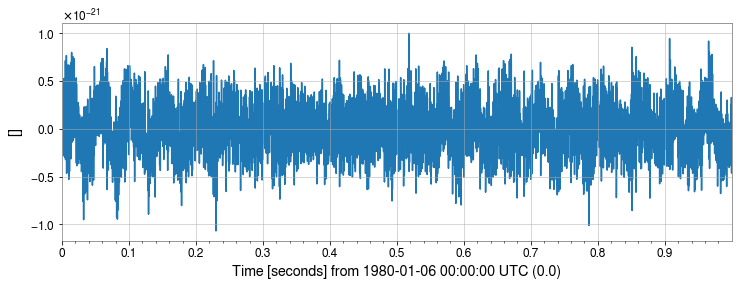

In [13]:
ts.plot();

In [14]:
asd = ts.asd();

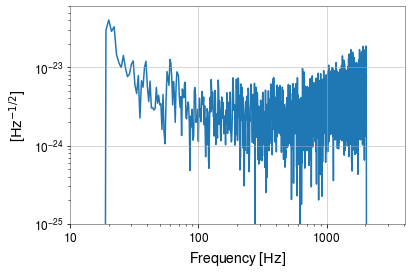

In [15]:
asd.plot();
plt.xlim(10,None);
plt.ylim(1E-25,6E-23);

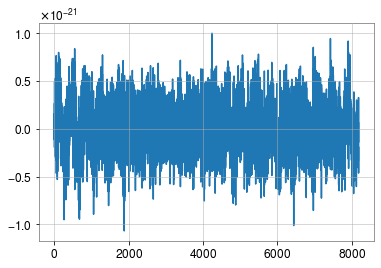

In [16]:
plt.plot(ts.value);

In [17]:
ts.sample_rate.value

8192.0

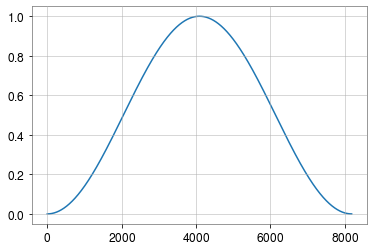

In [18]:

window = scipy.signal.windows.boxcar(len(ts))

window = scipy.signal.windows.hann(len(ts))
plt.plot(window)

In [19]:
freqs , Pxx = scipy.signal.welch(ts.value, 
                                 fs=ts.sample_rate.value,
                                 nperseg=len(ts),
                                 window=window)

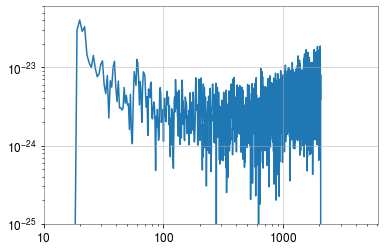

In [20]:
plt.loglog(freqs,np.sqrt(Pxx));
plt.xlim(10,None);
plt.ylim(1E-25,6E-23);

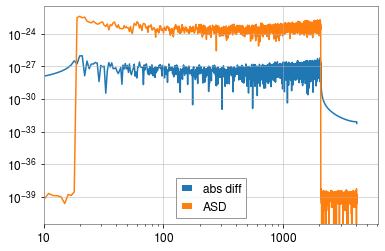

In [21]:
plt.loglog(freqs,np.abs(np.sqrt(Pxx)-asd.value), 
           label='abs diff');
plt.loglog(freqs, asd, label='ASD');
plt.xlim(10,None);
# plt.ylim(1E-25,6E-23);
plt.legend();

Copy and load the asd curve. 

In [22]:
psd_O4 = "/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py38/lib/python3.8/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt"

In [23]:
# !cp $psd_O4 ./

In [41]:
psd_name = "aLIGO_O4_high_asd"
psd_O4_array = np.loadtxt(psd_name + ".txt")

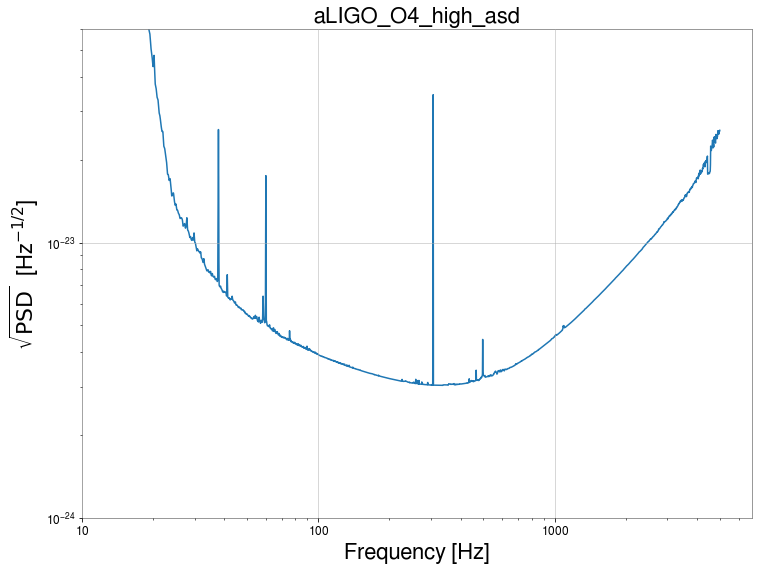

In [51]:
plt.figure(figsize=(12,9))
plt.loglog(psd_O4_array[:,0], psd_O4_array[:,1]);
plt.title(psd_name, fontsize=22)
plt.xlim(10,None);
plt.ylim(1E-24,6E-23);
plt.xlabel("Frequency [Hz]", fontsize=22);
plt.ylabel(r"$\sqrt{\mathrm{PSD}}\;\;$[Hz$^{-1/2}$]", fontsize=22);
plt.savefig(psd_name+".png")

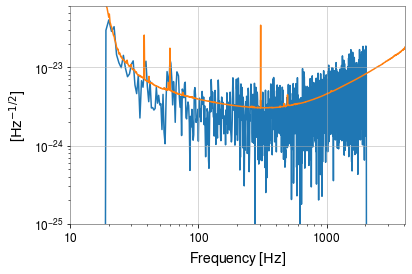

In [25]:
asd.plot();
ax=plt.gca();
plt.plot(psd_O4_array[:,0], psd_O4_array[:,1]);
plt.xlim(10,None);
plt.ylim(1E-25,6E-23);

## 4096 second segments from PSD

In [28]:
H1 = bilby.gw.detector.get_empty_interferometer('H1')
sampling_frequency = 8192
duration = 4096
H1.set_strain_data_from_power_spectral_density(sampling_frequency, duration, start_time=0)
ts = H1.strain_data.to_gwpy_timeseries()
asd = ts.asd();

In [29]:
import scipy.signal
window = scipy.signal.windows.boxcar(len(ts))

# window = scipy.signal.windows.hann(len(ts))
# plt.plot(window);

In [30]:
freqs , Pxx = scipy.signal.welch(ts.value, 
                                 fs=ts.sample_rate.value,
                                 nperseg=len(ts),
                                 window=window)

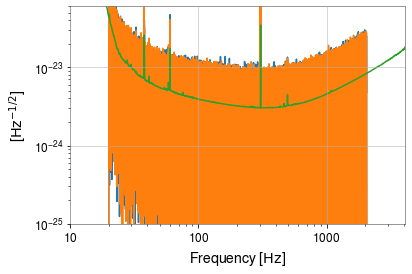

In [10]:
asd.plot()
plt.loglog(freqs,np.sqrt(Pxx));
plt.plot(psd_O4_array[:,0], psd_O4_array[:,1]);
plt.xlim(10,None);
plt.ylim(1E-25,6E-23);

In [31]:
fs = int(ts.sample_rate.value)
NFFT = 4 * fs;
NOVL = 1 * NFFT / 2
tukey_window = scipy.signal.tukey(NFFT, alpha=1./4)
time = ts.times.value

time_center = duration/2
indxt_away = np.where((time >= time_center - 512) & (
                time < time_center + 512))
short_indxt_away = np.where((time >= time_center - 2) & (
                time < time_center + 2))
ts_short = ts[short_indxt_away]
ts_1000 = ts[indxt_away]

In [32]:
import matplotlib.mlab as mlab
# psd with no window, no averaging

tuckey_Pxx, nowin_freqs = mlab.psd(
                ts_1000.value, Fs=fs, 
                NFFT=NFFT, window=tukey_window, 
                noverlap=NOVL)
# nowin_Pxx, nowin_freqs = mlab.psd(
#                 ts_1000.value, Fs=fs, 
#                 NFFT=NFFT, window=mlab.window_none)

asd_mlab_tukey = np.sqrt(tuckey_Pxx)
# asd_mlab_nowin = np.sqrt(nowin_Pxx)

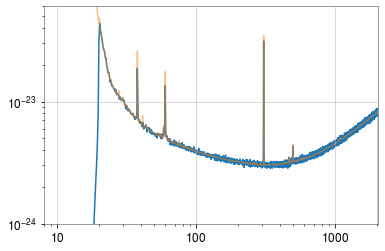

In [40]:
# asd.plot()
plt.loglog(nowin_freqs, asd_mlab_tukey);
# plt.loglog(freqs,np.sqrt(Pxx));
plt.plot(psd_O4_array[:,0], psd_O4_array[:,1], 
         alpha=0.5, label="PSD");

plt.xscale("log")
plt.xlim(2**3, 2**11);
plt.ylim(1E-24, 6E-23);

In [1]:
1+1

2

We don't see any spectral leakage because the PSD used to generate the data had an f_minimum of 20 Hz, while spectral leakage arises from a steep low frequency component. Get real LIGO data to see the leakage effect. **DONE**

It is not clear whether a 1 sec segment will be enough to whiten the data, since the peaks are not clear in the estimated PSD. Check first if this gets resolved after using a Welch average. Even if this does not work, maybe we can pretend that if we had access to a large amount of data before and after, we could evaluate the PSD more accurately.

In [243]:
def plot_fourier_phases(data, dt): 
    
    """Plots Fourier phases of strain data.

    Args:
        data (ndarray): strain data
        time (ndarray): time corresponding to data.
        
    From Notebook to accompany "A guide to LIGO-Virgo detector noise"
    """
    # do this both with and without a spectral window
    plt.figure(figsize=(8, 5))
    tukey_window = scipy.signal.tukey(data.size, alpha=1./8),
    labels = ['Tukey window', 'No window']
    colors = ['red', 'blue']
    
    # apply each window and find phases of the fft
    for i, dwindow in enumerate([tukey_window, 1]):
        data_fft = np.fft.rfft((data * dwindow).flatten()) * dt
        datafreq = np.fft.rfftfreq(data.size) / dt
        phases = np.angle(data_fft)
        # convert angles to range (0, 2 pi)
        phases = (phases + 2 * np.pi) % (2 * np.pi)
        plt.plot(datafreq, phases, '.', label=labels[i], 
                 color=colors[i], markersize=1)
        
    plt.xlim([20, 400])
    plt.ylim([0, 6])
    plt.xlabel('f(Hz)')
    plt.ylabel('Phase')
    plt.legend(loc='upper right', fontsize=7)

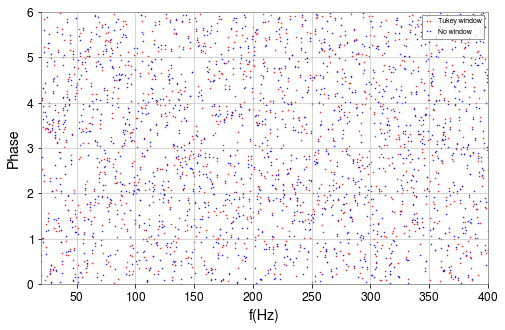

In [244]:
fs = int(ts_short.sample_rate.value)
dt = 1/fs
plot_fourier_phases(ts_short.value, dt=dt)

## GWpy Fetched Data

In [256]:
from gwpy.timeseries import TimeSeries
data_gds = TimeSeries.get('H1:GDS-CALIB_STRAIN', 1126259446, 1126259478)

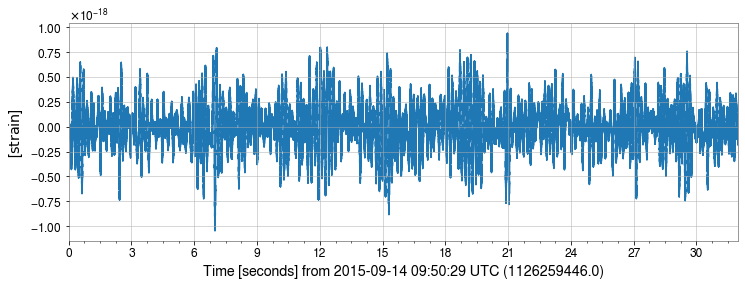

In [257]:
data_gds.plot();

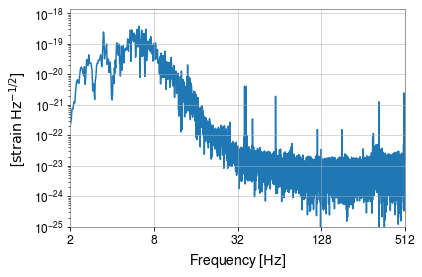

In [258]:
asd_gds = data_gds.asd()
asd_gds.plot();
plt.xscale("log", basex=2)
plt.xlim(2**1, 2**9);
plt.ylim(1E-25, None);

In [259]:
data_gds.sample_rate

<Quantity 16384. Hz>

In [265]:
data_gwosc = TimeSeries.fetch_open_data('H1', 1126259446, 1126259478)
# data_gwosc = TimeSeries.fetch_open_data('H1', 1126259460, 1126259464)

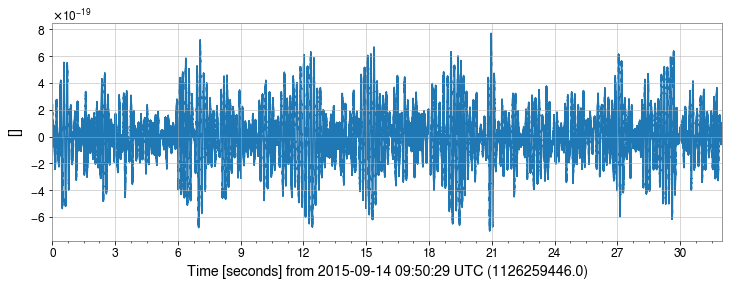

In [266]:
data_gwosc.plot();

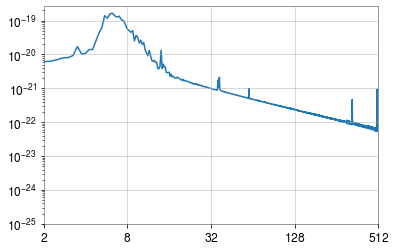

In [273]:
fs = int(data_gwosc.sample_rate.value)
NFFT = 4 * fs;
nowin_Pxx, nowin_freqs = mlab.psd(
                data_gwosc.value, Fs=fs, 
                NFFT=NFFT, window=mlab.window_none)
nowin_asd = np.sqrt(nowin_Pxx)
plt.plot(nowin_freqs, nowin_asd)
plt.xscale("log", basex=2)
plt.yscale("log", basey=10)
plt.xlim(2**1, 2**9);
plt.ylim(1E-25, None);

In [274]:
data_gwosc.sample_rate

<Quantity 4096. Hz>

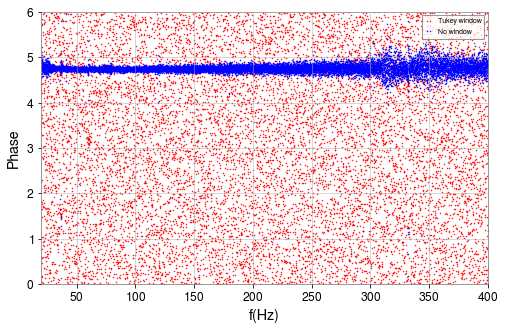

In [276]:
fs = int(data_gds.sample_rate.value)
dt = 1 / fs
plot_fourier_phases(data_gds.value, dt=dt)